### Fit binary AMT perception classifier with general features 
- previously developed 5 features: n\_opp, n\_sup, src\_probLR, n\_words, tar\_src\_posratio\_diff <br>
- class label: AMT_effect > 0 as pos, AMT_effect <= 0 as neg <br>

In [19]:
import pickle, random, re, ast, time #pydot
import pandas as pd
import numpy as np
from nltk import pos_tag
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import classification_report
import ast
from scipy.sparse import vstack
from sklearn.externals.six import StringIO 
from IPython.display import display
#from sklearn.datasets import load_iris
from sklearn import tree
from IPython.display import Image
from collections import Counter
# import seaborn as sns
from scipy.stats import pearsonr,spearmanr
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")
AMT_path = '/data/2/zwang/2018_S_WordTreatment/V2_AMT/'
project_path = '/data/2/zwang/2018_S_WordTreatment/'

In [3]:
coef_feats = ['src_coef','tar_coef','tar_src_dif_coef','n_sup','n_opp','n_words','src_prob']
effect_feats = ['combo_effect','src_ratio','tar_ratio','tar_src_dif_posratio']
LSE_effects_old = ['knn_effect','vt_effect','ctf_effect','csf_effect']
LSE_effects_leaf10 = ['knn_effect_sim0','vt_effect_leaf10','ctf_effect_leaf10','csf_effect_200leaf10','csf_effect_2000leaf10']
LSE_effects_new = ['KNN','VT','CTF','CSF_200','CSF_2000','CSF_param','weighted_KNN','combine_effect']
AMT_effects = ['amt_effect_mean','amt_effect_median','amt_effect_mostcom','AMT_quater_effect']
data_fullname = {'tw':'Twitter','yp':'Yelp','airbnb':'Airbnb'}

### Calculate result using only AMT labeled data

- Split training and testing by word pair <br>
> Testing set contains sentences of one word pair <br>
> Training set contains sentences of all word pairs except the testing one <br>

- Split training and testing by dataset <br>
> Testing set contains sentences of one dataset <br>
> Training set contains sentences of the other two datasets <br>
> Test if three datasets have same ['source','target'] pairs (Answer: no) , if they have same pairs, re-consider oob prediction<br>

- Fit classifier on training data and predict on testing samples <br>
- Calculate pearson and AUC_ROC between [estimated LSEs + predicted probabilities] and AMT_effect / labels <br>

#### Check if three datasets have same ['source','target'] pairs (Answer: no)

In [4]:
tw_pd = pd.read_csv(AMT_path+'AMT_WdSents/Effects/120/tw_AMT_120Combine.csv',index_col=False)
yp_pd = pd.read_csv(AMT_path+'AMT_WdSents/Effects/120/yp_AMT_120Combine.csv',index_col=False)
airbnb_pd = pd.read_csv(AMT_path+'AMT_WdSents/Effects/120/airbnb_AMT_120Combine.csv',index_col=False)

In [5]:
tw_test = tw_pd[['source','target']].drop_duplicates()

In [280]:
yp_test = yp_pd[['source','target']].drop_duplicates()

In [281]:
airbnb_test = airbnb_pd[['source','target']].drop_duplicates()

In [282]:
pd.merge(tw_test, yp_test, how='inner', on=['source','target'])

,source,target
0,yummy,tasty


In [283]:
pd.merge(tw_test, airbnb_test, how='inner', on=['source','target'])

,source,target


In [284]:
pd.merge(airbnb_test, yp_test, how='inner', on=['source','target'])

,source,target
0,yummy,delicious
1,yummy,good


In [4]:
# pretty_name = {}
# pretty_name['knn_effect'] = 'KNN'
# pretty_name['vt_effect'] = 'VT-RF'
# pretty_name['ctf_effect'] = 'CF-RF'
# pretty_name['csf_effect'] = 'CSF'
# pretty_name['predict_value'] = 'clf_predict'
# for ef in LSE_effects_leaf10:
#     pretty_name[ef] = ef

In [4]:
def read_data(data, train_style):
    """
    data: current dataset
    train_style:
    (=1) training on 2 datasets and predict on 1
    (=2) training on twitter, predicting on yelp; training on yelp, predicting on twitter; 
         training on twitter and yelp, predicting on airbnb.
    """    
    file_appendix = '_all_feats_leaf10_scaled.csv'
    testing_pd = pd.read_csv(project_path+'V2_'+data_fullname[data].lower()+'/9_Coef/'+data+file_appendix,index_col=False)
    train_str = ''
    if(train_style == 2):
        train_pd_list = []
        for di,train in enumerate(['yp','tw','airbnb']):
            if(train != data):
                train_str += train + ' & '
                train_pd_list.append(pd.read_csv(project_path+'V2_'+data_fullname[train].lower()+'/9_Coef/'+train+file_appendix,index_col=False))
        training_pd = pd.concat(train_pd_list, axis=0)
        print("Training on %s, testing on %s" % (train_str,data))
    elif(train_style == 1):
        testing_pd = pd.read_csv(project_path+'V2_'+data_fullname[data].lower()+'/9_Coef/'+data+file_appendix,index_col=False)
        if(data == 'yp'):
            training_pd = pd.read_csv(project_path+'V2_'+data_fullname['tw'].lower()+'/9_Coef/'+'tw'+file_appendix,index_col=False)
        elif(data == 'tw'):
            training_pd = pd.read_csv(project_path+'V2_'+data_fullname['yp'].lower()+'/9_Coef/'+'yp'+file_appendix,index_col=False)
        elif(data == 'airbnb'):
            train_pd_list = []
            train_pd_list.append(pd.read_csv(project_path+'V2_'+data_fullname['tw'].lower()+'/9_Coef/'+'tw'+file_appendix,index_col=False))
            train_pd_list.append(pd.read_csv(project_path+'V2_'+data_fullname['yp'].lower()+'/9_Coef/'+'yp'+file_appendix,index_col=False))
            training_pd = pd.concat(train_pd_list, axis=0)

    testing_pd = testing_pd.dropna(axis=0)
    training_pd = training_pd.dropna(axis=0)
    
    return training_pd,testing_pd

In [5]:
def fit_clf(data, training_pd, testing_pd, clf_feats, amt_effect,amt_thresh):
    """
    Fit binary classifier
    """
    pred_value = []
    pred_label = []

    LR_clf = LogisticRegression(random_state=42,n_jobs=-1)# class_weight = 'balanced'
#     LR_clf = RandomForestClassifier(random_state=42,n_jobs=-1)
#     LR_clf = DecisionTreeClassifier(random_state=42)

    LR_clf.fit(training_pd[clf_feats].values,training_pd[amt_effect].apply(lambda x: 1 if x>amt_thresh else 0).values)
    
#     pred_value =  np.dot(testing_pd[clf_feats].values, LR_clf.coef_[0]) + LR_clf.intercept_[0]
    
    pred_value.extend(np.array(LR_clf.predict_proba(testing_pd[clf_feats].values))[:,1])
    
    pred_label.extend(np.array(LR_clf.predict(testing_pd[clf_feats].values)))

    print(classification_report(testing_pd[amt_effect].apply(lambda x: 1 if x>amt_thresh else 0).values, pred_label))
    
    print(data_fullname[data],"Feature importance:\n")
    for fi in LR_clf.coef_[0].argsort()[::-1]:
        print("%.3f , %s" % (LR_clf.coef_[0][fi],clf_feats[fi]))
        
    return pred_value

In [6]:
def fit_linear(data, training_pd, testing_pd, clf_feats, amt_effect):
    """
    Fit linear regression
    """
    LR_linear = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=-1)
    LR_linear.fit(training_pd[clf_feats].values,training_pd[amt_effect])
    print('Error: {:.3f}'.format(LR_linear.score(testing_pd[clf_feats].values,testing_pd[amt_effect])))
   
    return np.array(LR_linear.predict(testing_pd[clf_feats].values))
        

In [7]:
def get_pearson(testing_pd, pears_feats, amt_effect):
    
#     fig,axs = plt.subplots(1,5,figsize=(15,3))
    pearson_corr_data = []
    for fti, feat in enumerate(pears_feats):
        pearson_corr_data.append((float('{:.3f}'.format(pearsonr(testing_pd[feat],testing_pd[amt_effect])[0])),
                                  float('{:.3f}'.format(pearsonr(testing_pd[feat],testing_pd[amt_effect])[1])))) 
        
#         axs[fti].scatter(testing_pd[feat],testing_pd[amt_effect])
#         axs[fti].set_title(feat)
        
    return pearson_corr_data

In [9]:
def get_lines():
    yield from ['s--', '*-', 'v-', '+:','r-'] # b,g,r,c,m,y,k
#    yield from ['c--', 'b-', 'm-.', 'g:','r+-'] # b,g,r,c,m,y,k
#     yield from ['co-', 'g*-', 'mx-', 'b+-','rd-']

In [10]:
def plot_roc_curve(testing_pd, pears_feats, amt_effect, data, sub_axs,amt_thresh):
    
    linecycler = get_lines()
    auc_roc_data = []
    
    for feat in pears_feats:
        amt_truth = testing_pd[amt_effect].apply(lambda x: 1 if x>amt_thresh else 0).values
        auc_score = float('{:.3f}'.format(roc_auc_score(amt_truth, testing_pd[feat])))
        auc_roc_data.append(auc_score)
        fpr, tpr, _ = roc_curve(amt_truth, testing_pd[feat])
        sub_axs.plot(fpr, tpr, next(linecycler), alpha=1, linewidth=2, label=pretty_name[feat]+' ('+str(auc_score)+')')
        
    sub_axs.set_title(data_fullname[data],fontweight="bold", size=30)
    sub_axs.plot([0, 1], [0, 1], color='gray', linestyle='--', alpha=.7)
    
    my_font = FontProperties(size=14,weight = 'bold')
    sub_axs.legend(loc='lower right', prop=my_font, frameon=False)  
    
    return auc_roc_data

In [27]:
def plot_precision_recall_curve(testing_pd, pears_feats, amt_effect, data, sub_axs,amt_thresh):
    
    linecycler = get_lines()
    
    for feat in pears_feats:
        amt_truth = testing_pd[amt_effect].apply(lambda x: 1 if x>amt_thresh else 0).values
        prec, rec, _ = precision_recall_curve(amt_truth, testing_pd[feat])
        avg_precision = float('{:.3f}'.format(average_precision_score(amt_truth, testing_pd[feat],average="micro")))
        sub_axs.plot(prec, rec, next(linecycler), alpha=1, linewidth=2, label=pretty_name[feat]+' ('+str(avg_precision)+')')

        
    sub_axs.set_title(data_fullname[data],fontweight="bold", size=30)
    sub_axs.plot([0, 1], [1, 0], color='gray', linestyle='--', alpha=.7)
    
    my_font = FontProperties(size=13,weight = 'bold')
    sub_axs.legend(loc='upper right', prop=my_font, frameon=False)  
    
    return

In [14]:
pretty_name = {}
pretty_name['knn_effect_sim0'] = 'KNN'
pretty_name['vt_effect_leaf10'] = 'VT-RF'
pretty_name['ctf_effect_leaf10'] = 'CF-RF'
pretty_name['csf_effect_200leaf10'] = 'CSF'
pretty_name['predict_value'] = 'Classifier'

In [25]:
def OOB_dataset_prediction(AMT_path,clf_feats,LSE_feats,amt_effect,train_style,model,amt_thresh):
    """
    clf_feats: features to fit AMT classifier
    LSE_feats: estimated LSE results to calculate pearson correlation
    OOB: (1) Fit on 2 datasets and predict on one; (2) Fit on Twitter, predict on Yelp; Fit on Yelp, predict on Twitter.
    """
    # 3 subplots, one for each dataset
    fig,axs = plt.subplots(1,3,figsize=(15,6.5))#,,sharex=True,sharey=True
    fig_pr,axs_pr = plt.subplots(1,3,figsize=(18,5))#,,sharex=True,sharey=True
    
    all_auc = {}
    pearson_corr = {}
    for idx, data in enumerate(['yp','tw','airbnb']):
        print('\nProcessing ',data_fullname[data],':')
        
        pearson_corr[data] = []
        all_auc[data] = []
        
        # process to get training and testing data, 2 styles for oob prediction
        training_pd, testing_pd = read_data(data, train_style)
        
        # Fit classifier, get oob_prediction and confusion matrix for test data
#         amt_truth = testing_pd[amt_effect].apply(lambda x: 1 if x>0 else 0).values
        if(model == 'classifier'):
            testing_pd['predict_value'] = fit_clf(data, training_pd, testing_pd, clf_feats, amt_effect, amt_thresh)  
        elif(model == 'linear'):
            testing_pd['predict_value'] = fit_linear(data, training_pd, testing_pd, clf_feats, amt_effect)
        
        # Calculate pearson correlation
        pearson_corr[data] = get_pearson(testing_pd, LSE_feats+['predict_value'], amt_effect)
        
        # Calculate and plot AUC_ROC
        axs[idx].tick_params(axis = 'both', which = 'major', labelsize = 20)
        all_auc[data] = plot_roc_curve(testing_pd, LSE_feats+['predict_value'], amt_effect, data, axs[idx], amt_thresh)
        
        # Calculate and plot precision recall curve
        axs_pr[idx].tick_params(axis = 'both', which = 'major', labelsize = 20)
        plot_precision_recall_curve(testing_pd, LSE_feats+['predict_value'], amt_effect, data, axs_pr[idx], amt_thresh)
        
    
    # Aggregate results for three datasets
    print("\nPearson correlation:")
    display(pd.DataFrame(pearson_corr,columns=['yp','tw','airbnb']).rename(columns={data:data_fullname[data] for data in data_fullname},
                                      index={i: fti for i, fti in enumerate(LSE_feats+['pred_value'])}))
    
    print("AUC_ROC:")
    display(pd.DataFrame(all_auc,columns=['yp','tw','airbnb']).rename(columns={data:data_fullname[data] for data in data_fullname},
                                         index={i: fti for i, fti in enumerate(LSE_feats+['pred_value'])}))
    
    axs[1].set_xlabel('False positive rate', size=30)
    axs[0].set_ylabel('True positive rate', size=30)
    
    axs_pr[1].set_xlabel('Recall', size=30)
    axs_pr[0].set_ylabel('Precision', size=30)
      
    plt.tight_layout()
    plt.savefig('AMTplot3.png',bbox_inches='tight')
    plt.show()


Processing  Yelp :
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        67
           1       1.00      0.25      0.40        48

   micro avg       0.69      0.69      0.69       115
   macro avg       0.83      0.62      0.59       115
weighted avg       0.80      0.69      0.63       115

Yelp Feature importance:

0.189 , tar_coef
-0.141 , src_coef
-0.348 , src_probLR

Processing  Twitter :
              precision    recall  f1-score   support

           0       0.72      0.99      0.83        78
           1       0.67      0.06      0.11        32

   micro avg       0.72      0.72      0.72       110
   macro avg       0.69      0.52      0.47       110
weighted avg       0.70      0.72      0.62       110

Twitter Feature importance:

0.401 , tar_coef
-0.514 , src_coef
-0.829 , src_probLR

Processing  Airbnb :
              precision    recall  f1-score   support

           0       0.81      1.00      0.89        97
       

,Yelp,Twitter,Airbnb
knn_effect_sim0,"(0.474, 0.0)","(0.291, 0.002)","(0.076, 0.41)"
vt_effect_leaf10,"(0.747, 0.0)","(0.333, 0.0)","(0.049, 0.596)"
ctf_effect_leaf10,"(0.68, 0.0)","(0.279, 0.003)","(0.109, 0.238)"
csf_effect_200leaf10,"(0.645, 0.0)","(0.338, 0.0)","(0.096, 0.295)"
pred_value,"(0.783, 0.0)","(0.21, 0.028)","(0.139, 0.13)"


AUC_ROC:


,Yelp,Twitter,Airbnb
knn_effect_sim0,0.571,0.621,0.545
vt_effect_leaf10,0.707,0.657,0.499
ctf_effect_leaf10,0.617,0.613,0.573
csf_effect_200leaf10,0.607,0.622,0.529
pred_value,0.803,0.583,0.548


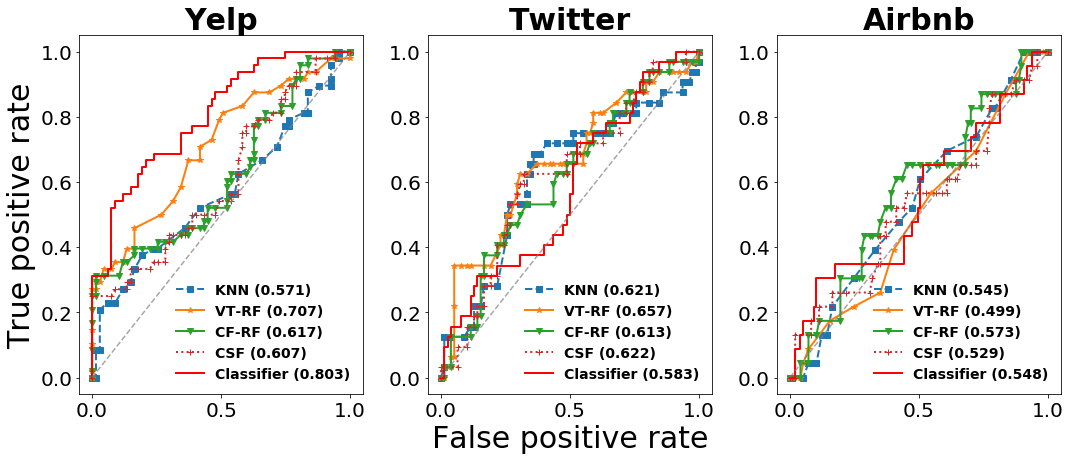

In [130]:
clf_feats = ['src_coef','tar_coef','src_probLR']#'n_sup','n_opp','n_words'
OOB_dataset_prediction(AMT_path,clf_feats, 
                       LSE_feats=['knn_effect_sim0','vt_effect_leaf10','ctf_effect_leaf10','csf_effect_200leaf10'], 
                       amt_effect='amt_effect_median', train_style=1, model='classifier',amt_thresh=0.5)


Processing  Yelp :
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        67
           1       1.00      0.25      0.40        48

   micro avg       0.69      0.69      0.69       115
   macro avg       0.83      0.62      0.59       115
weighted avg       0.80      0.69      0.63       115

Yelp Feature importance:

0.189 , tar_coef
-0.141 , src_coef
-0.348 , src_probLR

Processing  Twitter :
              precision    recall  f1-score   support

           0       0.72      0.99      0.83        78
           1       0.67      0.06      0.11        32

   micro avg       0.72      0.72      0.72       110
   macro avg       0.69      0.52      0.47       110
weighted avg       0.70      0.72      0.62       110

Twitter Feature importance:

0.401 , tar_coef
-0.514 , src_coef
-0.829 , src_probLR

Processing  Airbnb :
              precision    recall  f1-score   support

           0       0.81      1.00      0.89        97
       

,Yelp,Twitter,Airbnb
knn_effect_sim0,"(0.474, 0.0)","(0.291, 0.002)","(0.076, 0.41)"
vt_effect_leaf10,"(0.747, 0.0)","(0.333, 0.0)","(0.049, 0.596)"
ctf_effect_leaf10,"(0.68, 0.0)","(0.279, 0.003)","(0.109, 0.238)"
csf_effect_200leaf10,"(0.645, 0.0)","(0.338, 0.0)","(0.096, 0.295)"
pred_value,"(0.783, 0.0)","(0.21, 0.028)","(0.139, 0.13)"


AUC_ROC:


,Yelp,Twitter,Airbnb
knn_effect_sim0,0.571,0.621,0.545
vt_effect_leaf10,0.707,0.657,0.499
ctf_effect_leaf10,0.617,0.613,0.573
csf_effect_200leaf10,0.607,0.622,0.529
pred_value,0.803,0.583,0.548


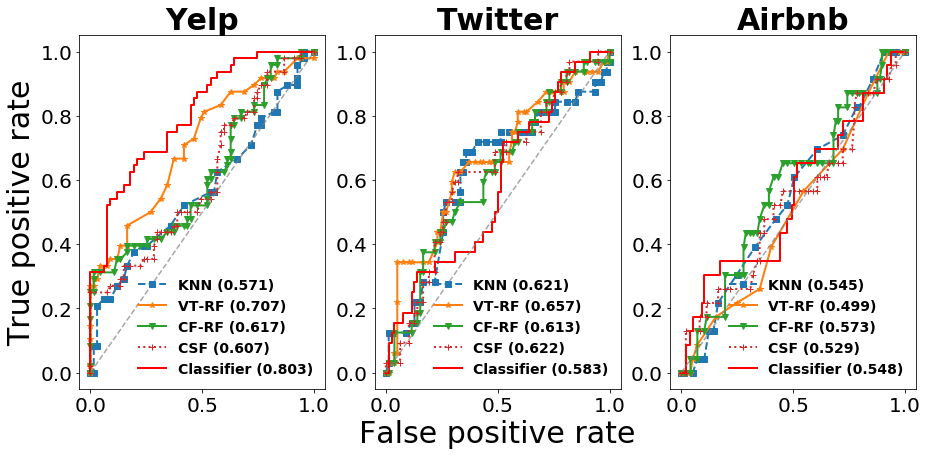

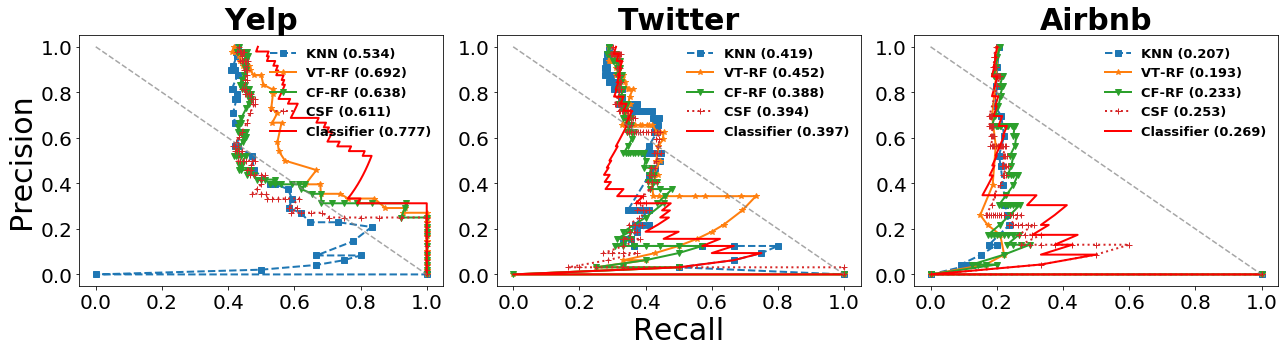

In [28]:
clf_feats = ['src_coef','tar_coef','src_probLR']#'n_sup','n_opp','n_words'
OOB_dataset_prediction(AMT_path,clf_feats, 
                       LSE_feats=['knn_effect_sim0','vt_effect_leaf10','ctf_effect_leaf10','csf_effect_200leaf10'], 
                       amt_effect='amt_effect_median', train_style=1, model='classifier',amt_thresh=0.5)

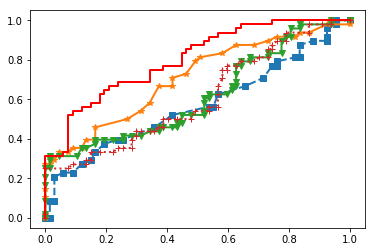

In [73]:
linecycler = get_lines()
for i in range(len(fpr_list)):
    plt.plot(fpr_list[i], tpr_list[i], next(linecycler), alpha=1, linewidth=2)


Processing  Yelp :
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        67
           1       1.00      0.25      0.40        48

   micro avg       0.69      0.69      0.69       115
   macro avg       0.83      0.62      0.59       115
weighted avg       0.80      0.69      0.63       115

Yelp Feature importance:

0.189 , tar_coef
-0.141 , src_coef
-0.348 , src_probLR


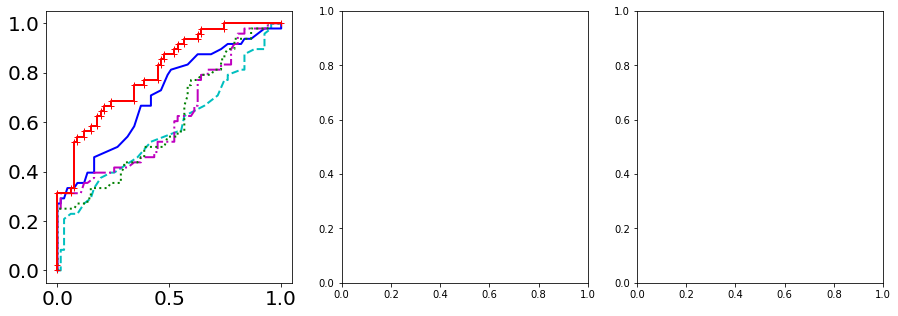

In [14]:
#clf_feats = ['src_coef','tar_coef','src_scaledcoef','tar_scaledcoef','tar_src_dif_coef','n_sup','n_opp','src_pos_ratio','tar_pos_ratio','n_words','tar_src_dif_posratio','src_probLR','tar_probLR']
clf_feats = ['src_coef','tar_coef','src_probLR']#'n_sup','n_opp','n_words'
fpr_list, tpr_list=OOB_dataset_prediction(AMT_path,clf_feats, 
                       LSE_feats=['knn_effect_sim0','vt_effect_leaf10','ctf_effect_leaf10','csf_effect_200leaf10'], 
                       amt_effect='amt_effect_median', train_style=1, model='classifier',amt_thresh=0.5)


Processing  Yelp :
             precision    recall  f1-score   support

          0       0.65      1.00      0.79        67
          1       1.00      0.25      0.40        48

avg / total       0.80      0.69      0.63       115

Yelp Feature importance:

0.189 , tar_coef
-0.141 , src_coef
-0.348 , src_probLR

Processing  Twitter :
             precision    recall  f1-score   support

          0       0.72      0.99      0.83        78
          1       0.67      0.06      0.11        32

avg / total       0.70      0.72      0.62       110

Twitter Feature importance:

0.401 , tar_coef
-0.514 , src_coef
-0.829 , src_probLR

Processing  Airbnb :
             precision    recall  f1-score   support

          0       0.81      1.00      0.89        97
          1       0.00      0.00      0.00        23

avg / total       0.65      0.81      0.72       120

Airbnb Feature importance:

0.344 , tar_coef
-0.367 , src_coef
-0.528 , src_probLR

Pearson correlation:


,Yelp,Twitter,Airbnb
knn_effect_sim0,"(0.474, 0.0)","(0.291, 0.002)","(0.076, 0.41)"
vt_effect_leaf10,"(0.747, 0.0)","(0.333, 0.0)","(0.049, 0.596)"
ctf_effect_leaf10,"(0.68, 0.0)","(0.279, 0.003)","(0.109, 0.238)"
csf_effect_200leaf10,"(0.645, 0.0)","(0.338, 0.0)","(0.096, 0.295)"
pred_value,"(0.783, 0.0)","(0.21, 0.028)","(0.139, 0.13)"


AUC_ROC:


,Yelp,Twitter,Airbnb
knn_effect_sim0,0.571,0.621,0.545
vt_effect_leaf10,0.707,0.657,0.499
ctf_effect_leaf10,0.617,0.613,0.573
csf_effect_200leaf10,0.607,0.622,0.529
pred_value,0.803,0.583,0.548


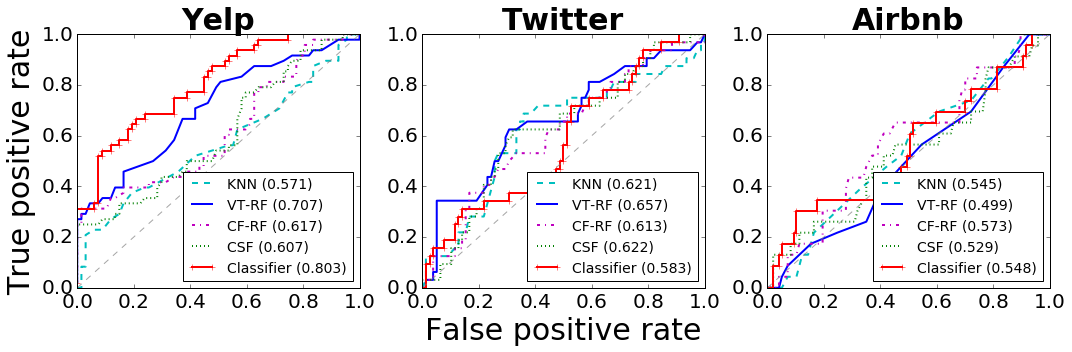

In [111]:
#clf_feats = ['src_coef','tar_coef','src_scaledcoef','tar_scaledcoef','tar_src_dif_coef','n_sup','n_opp','src_pos_ratio','tar_pos_ratio','n_words','tar_src_dif_posratio','src_probLR','tar_probLR']
clf_feats = ['src_coef','tar_coef','src_probLR']#'n_sup','n_opp','n_words'
OOB_dataset_prediction(AMT_path,clf_feats, 
                       LSE_feats=['knn_effect_sim0','vt_effect_leaf10','ctf_effect_leaf10','csf_effect_200leaf10'], 
                       amt_effect='amt_effect_median', train_style=1, model='classifier',amt_thresh=0.5)


Processing  Yelp :
             precision    recall  f1-score   support

          0       0.65      1.00      0.79        67
          1       1.00      0.25      0.40        48

avg / total       0.80      0.69      0.63       115

Yelp Feature importance:

0.189 , tar_coef
-0.141 , src_coef
-0.348 , src_probLR

Processing  Twitter :
             precision    recall  f1-score   support

          0       0.72      0.99      0.83        78
          1       0.67      0.06      0.11        32

avg / total       0.70      0.72      0.62       110

Twitter Feature importance:

0.401 , tar_coef
-0.514 , src_coef
-0.829 , src_probLR

Processing  Airbnb :
             precision    recall  f1-score   support

          0       0.81      1.00      0.89        97
          1       0.00      0.00      0.00        23

avg / total       0.65      0.81      0.72       120

Airbnb Feature importance:

0.344 , tar_coef
-0.367 , src_coef
-0.528 , src_probLR

Pearson correlation:


,Yelp,Twitter,Airbnb
knn_effect_sim0,"(0.474, 0.0)","(0.291, 0.002)","(0.076, 0.41)"
vt_effect_leaf10,"(0.747, 0.0)","(0.333, 0.0)","(0.049, 0.596)"
ctf_effect_leaf10,"(0.68, 0.0)","(0.279, 0.003)","(0.109, 0.238)"
csf_effect_200leaf10,"(0.645, 0.0)","(0.338, 0.0)","(0.096, 0.295)"
pred_value,"(0.772, 0.0)","(0.192, 0.045)","(0.111, 0.228)"


AUC_ROC:


,Yelp,Twitter,Airbnb
knn_effect_sim0,0.571,0.621,0.545
vt_effect_leaf10,0.707,0.657,0.499
ctf_effect_leaf10,0.617,0.613,0.573
csf_effect_200leaf10,0.607,0.622,0.529
pred_value,0.803,0.583,0.548


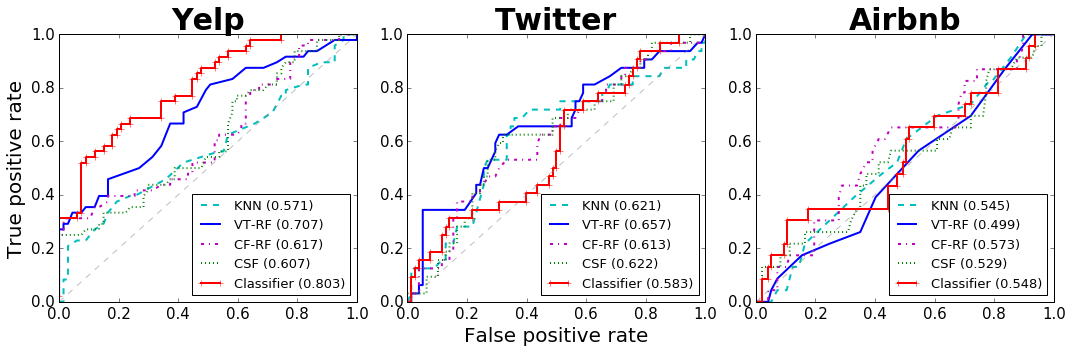

In [88]:
#clf_feats = ['src_coef','tar_coef','src_scaledcoef','tar_scaledcoef','tar_src_dif_coef','n_sup','n_opp','src_pos_ratio','tar_pos_ratio','n_words','tar_src_dif_posratio','src_probLR','tar_probLR']
clf_feats = ['src_coef','tar_coef','src_probLR']#'n_sup','n_opp','n_words'
OOB_dataset_prediction(AMT_path,clf_feats, 
                       LSE_feats=['knn_effect_sim0','vt_effect_leaf10','ctf_effect_leaf10','csf_effect_200leaf10'], 
                       amt_effect='amt_effect_median', train_style=1, model='classifier',amt_thresh=0.5)


Processing  Yelp :
Training on tw & airbnb & , testing on yp
             precision    recall  f1-score   support

          0       0.86      0.48      0.62        52
          1       0.69      0.94      0.79        63

avg / total       0.77      0.73      0.71       115

Yelp Feature importance:

0.277 , tar_coef
-0.148 , src_coef
-0.822 , src_probLR

Processing  Twitter :
Training on yp & airbnb & , testing on tw
             precision    recall  f1-score   support

          0       0.54      0.89      0.68        56
          1       0.67      0.22      0.33        54

avg / total       0.60      0.56      0.51       110

Twitter Feature importance:

0.378 , tar_coef
-0.053 , src_probLR
-0.367 , src_coef

Processing  Airbnb :
Training on yp & tw & , testing on airbnb
             precision    recall  f1-score   support

          0       0.72      1.00      0.84        86
          1       1.00      0.03      0.06        34

avg / total       0.80      0.72      0.62       120


,Yelp,Twitter,Airbnb
knn_effect_sim0,"(0.474, 0.0)","(0.291, 0.002)","(0.076, 0.41)"
vt_effect_leaf10,"(0.747, 0.0)","(0.333, 0.0)","(0.049, 0.596)"
ctf_effect_leaf10,"(0.68, 0.0)","(0.279, 0.003)","(0.109, 0.238)"
csf_effect_200leaf10,"(0.645, 0.0)","(0.338, 0.0)","(0.096, 0.295)"
pred_prob,"(0.704, 0.0)","(0.201, 0.036)","(0.108, 0.238)"


AUC_ROC:


,Yelp,Twitter,Airbnb
knn_effect_sim0,0.620,0.646,0.563
vt_effect_leaf10,0.696,0.694,0.534
ctf_effect_leaf10,0.633,0.626,0.577
csf_effect_200leaf10,0.628,0.620,0.569
pred_prob,0.773,0.572,0.598


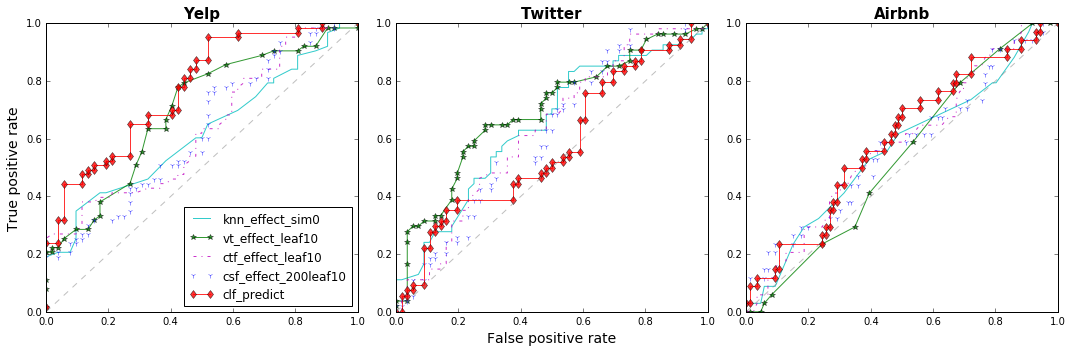

In [174]:
#clf_feats = ['src_coef','tar_coef','tar_src_dif_coef','n_sup','n_opp','src_pos_ratio','tar_pos_ratio','n_words','tar_src_dif_posratio','src_probLR','tar_probLR']
clf_feats = ['src_coef','tar_coef','src_probLR']#'n_sup','n_opp','n_words'
OOB_dataset_prediction(AMT_path,clf_feats, 
                       LSE_feats=['knn_effect_sim0','vt_effect_leaf10','ctf_effect_leaf10','csf_effect_200leaf10'], 
                       amt_effect='amt_effect_median', train_style=2,model='classifier')


Processing  Yelp :
             precision    recall  f1-score   support

          0       0.87      0.47      0.61        55
          1       0.68      0.94      0.79        65

avg / total       0.76      0.72      0.71       120

Yelp Feature importance:

0.230 , tar_coef
-0.159 , src_coef
-0.903 , src_probLR

Processing  Twitter :
             precision    recall  f1-score   support

          0       0.53      0.90      0.67        60
          1       0.67      0.20      0.31        60

avg / total       0.60      0.55      0.49       120

Twitter Feature importance:

0.389 , tar_coef
0.003 , src_probLR
-0.369 , src_coef

Processing  Airbnb :
             precision    recall  f1-score   support

          0       0.72      1.00      0.84        86
          1       1.00      0.03      0.06        34

avg / total       0.80      0.72      0.62       120

Airbnb Feature importance:

0.332 , tar_coef
-0.239 , src_coef
-0.597 , src_probLR
Pearson correlation:


,Yelp,Twitter,Airbnb
knn_effect_sim0,"(0.459, 0.0)","(0.269, 0.003)","(0.076, 0.41)"
vt_effect_leaf10,"(0.741, 0.0)","(0.321, 0.0)","(0.049, 0.596)"
ctf_effect_leaf10,"(0.664, 0.0)","(0.263, 0.004)","(0.109, 0.238)"
csf_effect_200leaf10,"(0.629, 0.0)","(0.321, 0.0)","(0.096, 0.295)"
classifier,"(0.698, 0.0)","(0.194, 0.034)","(0.11, 0.233)"


AUC_ROC:


,Yelp,Twitter,Airbnb
knn_effect_sim0,0.622,0.611,0.563
vt_effect_leaf10,0.693,0.669,0.534
ctf_effect_leaf10,0.636,0.614,0.577
csf_effect_200leaf10,0.630,0.608,0.569
classifier,0.758,0.552,0.598


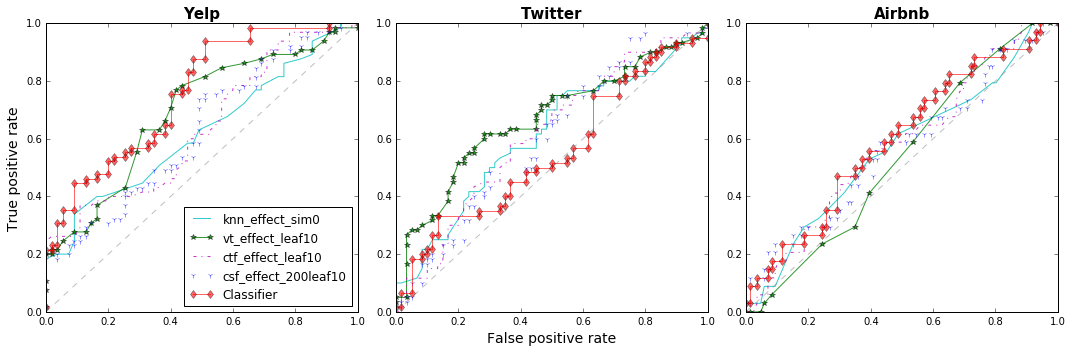

In [124]:
#clf_feats = ['src_coef','tar_coef','tar_src_dif_coef','n_sup','n_opp','src_pos_ratio','tar_pos_ratio','n_words','tar_src_dif_posratio','src_probLR','tar_probLR']
clf_feats = ['src_coef','tar_coef','src_probLR']#'n_sup','n_opp','n_words'
OOB_dataset_prediction(AMT_path,clf_feats, 
                       LSE_feats=['knn_effect_sim0','vt_effect_leaf10','ctf_effect_leaf10','csf_effect_200leaf10'], 
                       amt_effect='amt_effect_median', flag='old')


Processing  Yelp :
             precision    recall  f1-score   support

          0       0.82      0.51      0.63        55
          1       0.69      0.91      0.78        65

avg / total       0.75      0.72      0.71       120

Feature importance:

0.231 , tar_coef
0.066 , n_sup
-0.010 , n_words
-0.073 , n_opp
-0.157 , src_coef
-1.118 , src_probLR

Processing  Twitter :
             precision    recall  f1-score   support

          0       0.54      0.85      0.66        60
          1       0.65      0.28      0.40        60

avg / total       0.60      0.57      0.53       120

Feature importance:

0.413 , tar_coef
0.013 , n_words
-0.025 , src_probLR
-0.058 , n_sup
-0.061 , n_opp
-0.376 , src_coef

Processing  Airbnb :
             precision    recall  f1-score   support

          0       0.72      1.00      0.84        86
          1       0.00      0.00      0.00        33

avg / total       0.52      0.72      0.61       119

Feature importance:

0.470 , tar_coef
0.150 , 

,Airbnb,Twitter,Yelp
knn_effect_sim0,0.075,0.269,0.459
vt_effect_leaf10,0.050,0.321,0.741
ctf_effect_leaf10,0.110,0.263,0.664
csf_effect_200leaf10,0.098,0.321,0.629
classifier,0.025,0.234,0.678


AUC_ROC:


,Airbnb,Twitter,Yelp
knn_effect_sim0,0.561,0.611,0.622
vt_effect_leaf10,0.534,0.669,0.693
ctf_effect_leaf10,0.581,0.614,0.636
csf_effect_200leaf10,0.572,0.608,0.630
classifier,0.501,0.575,0.821


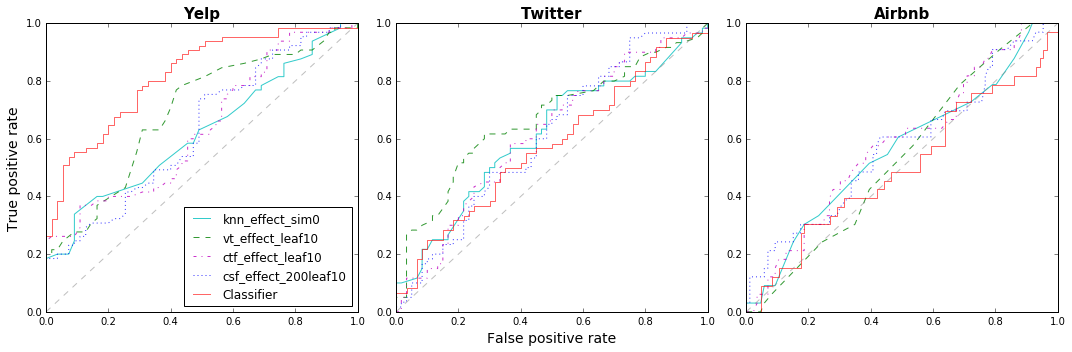

In [7]:
#clf_feats = ['src_coef','tar_coef','tar_src_dif_coef','n_sup','n_opp','src_pos_ratio','tar_pos_ratio','n_words','tar_src_dif_posratio','src_probLR','tar_probLR']
clf_feats = ['src_coef','tar_coef','n_sup','n_opp','n_words','src_probLR']
OOB_dataset_prediction(AMT_path,clf_feats, LSE_feats=['knn_effect_sim0','vt_effect_leaf10','ctf_effect_leaf10','csf_effect_200leaf10'], 
                       amt_effect='amt_effect_median', flag='old')


Processing  Yelp :
             precision    recall  f1-score   support

          0       0.82      0.51      0.63        55
          1       0.69      0.91      0.78        65

avg / total       0.75      0.72      0.71       120

Feature importance:

0.231 , tar_coef
0.066 , n_sup
-0.010 , n_words
-0.073 , n_opp
-0.157 , src_coef
-1.118 , src_probLR

Processing  Twitter :
             precision    recall  f1-score   support

          0       0.54      0.85      0.66        60
          1       0.65      0.28      0.40        60

avg / total       0.60      0.57      0.53       120

Feature importance:

0.413 , tar_coef
0.013 , n_words
-0.025 , src_probLR
-0.058 , n_sup
-0.061 , n_opp
-0.376 , src_coef

Processing  Airbnb :
             precision    recall  f1-score   support

          0       0.72      1.00      0.84        86
          1       0.00      0.00      0.00        33

avg / total       0.52      0.72      0.61       119

Feature importance:

0.470 , tar_coef
0.150 , 

,Airbnb,Twitter,Yelp
knn_effect,0.055,0.233,0.379
vt_effect,0.021,0.267,0.508
ctf_effect,-0.002,0.274,0.574
csf_effect,-0.020,0.220,0.531
classifier,0.025,0.234,0.678


AUC_ROC:


,Airbnb,Twitter,Yelp
knn_effect,0.541,0.623,0.635
vt_effect,0.539,0.623,0.720
ctf_effect,0.537,0.629,0.690
csf_effect,0.522,0.565,0.605
classifier,0.501,0.575,0.821


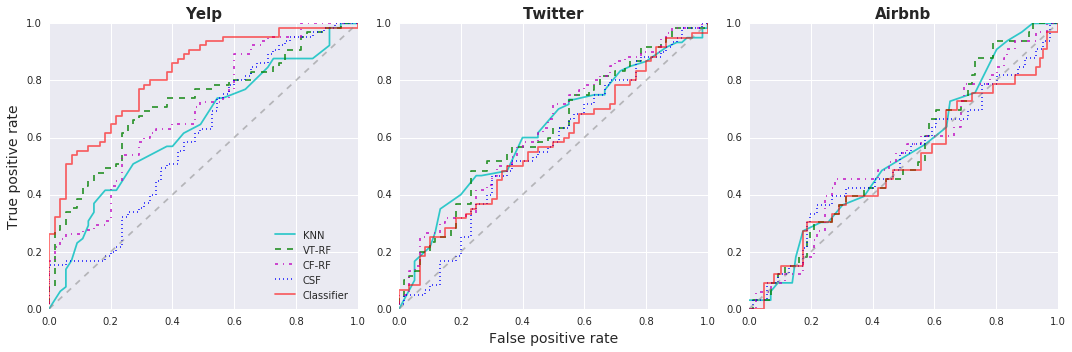

In [153]:
#clf_feats = ['src_coef','tar_coef','tar_src_dif_coef','n_sup','n_opp','src_pos_ratio','tar_pos_ratio','n_words','tar_src_dif_posratio','src_probLR','tar_probLR']
clf_feats = ['src_coef','tar_coef','n_sup','n_opp','n_words','src_probLR']
OOB_dataset_prediction(AMT_path,clf_feats, LSE_feats=LSE_effects_old, amt_effect='amt_effect_median', flag='old')

#### Linear Regression


Processing  Yelp :
Training on tw & airbnb & , testing on yp
Error: 0.194

Processing  Twitter :
Training on yp & airbnb & , testing on tw
Error: -0.219

Processing  Airbnb :
Training on yp & tw & , testing on airbnb
Error: -1.036
Pearson correlation:


,Yelp,Twitter,Airbnb
knn_effect_sim0,"(0.474, 0.0)","(0.291, 0.002)","(0.076, 0.41)"
vt_effect_leaf10,"(0.747, 0.0)","(0.333, 0.0)","(0.049, 0.596)"
ctf_effect_leaf10,"(0.68, 0.0)","(0.279, 0.003)","(0.109, 0.238)"
csf_effect_200leaf10,"(0.645, 0.0)","(0.338, 0.0)","(0.096, 0.295)"
pred_prob,"(0.629, 0.0)","(0.064, 0.507)","(0.096, 0.298)"


AUC_ROC:


,Yelp,Twitter,Airbnb
knn_effect_sim0,0.620,0.646,0.563
vt_effect_leaf10,0.696,0.694,0.534
ctf_effect_leaf10,0.633,0.626,0.577
csf_effect_200leaf10,0.628,0.620,0.569
pred_prob,0.758,0.541,0.601


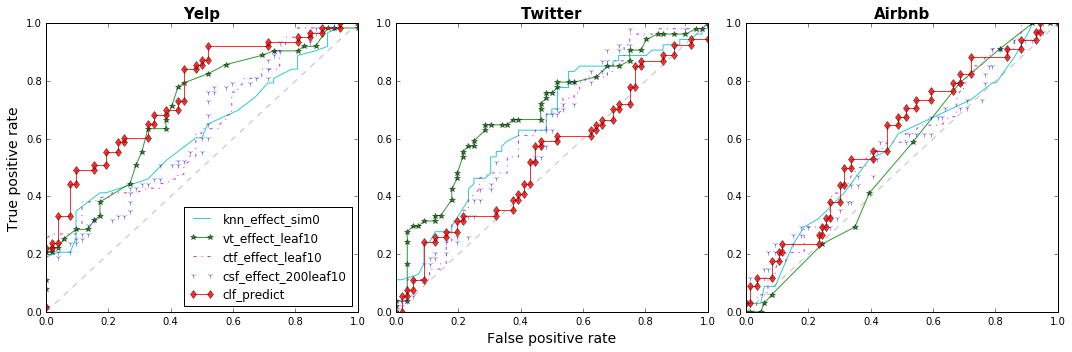

In [176]:
#clf_feats = ['src_coef','tar_coef','tar_src_dif_coef','n_sup','n_opp','src_pos_ratio','tar_pos_ratio','n_words','tar_src_dif_posratio','src_probLR','tar_probLR']
clf_feats = ['src_coef','tar_coef','src_probLR']#'n_sup','n_opp','n_words'
OOB_dataset_prediction(AMT_path,clf_feats, 
                       LSE_feats=['knn_effect_sim0','vt_effect_leaf10','ctf_effect_leaf10','csf_effect_200leaf10'], 
                       amt_effect='amt_effect_median', train_style=2,model='linear')

#### Split by word pair

In [ ]:
def OOB_wdpair_prediction(AMT_path,clf_feats,LSE_feats,amt_effect,flag):
    """
    clf_feats: features to fit AMT classifier
    LSE_feats: estimated LSE results to calculate pearson correlation
    """
    all_auc = {}
    pearson_corr = {}
    for di, data in enumerate(['tw','yp','airbnb']):
        print('\nProcessing ',data_fullname[data],':')
        if(flag == 'new'):
            data_pd = pd.read_csv(AMT_path+'AMT_WdSents/Effects/'+data+'_AMT_AllCombine.csv',index_col=False) # For selected sentences
        elif(flag == 'old'):
            data_pd = pd.read_csv(project_path+'V2_'+data_fullname[data].lower()+'/9_Coef/'+data+'_all_feats.csv',index_col=False)
        # Split data into training and testing
        pair_pd = data_pd[['source','target']].drop_duplicates()
        pred_prob = []
        pred_label = []
        amt_truth = []
        for idx, wdpair in pair_pd.iterrows():
            training_pd = data_pd[(data_pd['source'] != wdpair['source']) & (data_pd['target'] != wdpair['target'])]
            testing_pd = data_pd[(data_pd['source'] == wdpair['source']) & (data_pd['target'] == wdpair['target'])]
            
            # Fit binary classifier
            LR_clf = LogisticRegression(random_state=42,n_jobs=-1)
            
            LR_clf.fit(training_pd[clf_feats].values,training_pd[amt_effect].apply(lambda x: 1 if x>0 else 0).values)
            pred_prob.extend(np.array(LR_clf.predict_proba(testing_pd[clf_feats].values))[:,1])
            pred_label.extend(np.array(LR_clf.predict(testing_pd[clf_feats].values)))
            amt_truth.extend(testing_pd[amt_effect].apply(lambda x: 1 if x>0 else 0).values)
            
        pearson_corr[data] = []
        all_auc[data] = []
        for feat in LSE_feats:
            pearson_corr[data].append(pearsonr(data_pd[feat],data_pd[amt_effect])[0]) # double check
            all_auc[data].append(float('{:.3f}'.format(roc_auc_score(amt_truth, data_pd[feat]))))
        pearson_corr[data].append(float('{:.3f}'.format(pearsonr(pred_prob,data_pd[amt_effect])[0])))
        all_auc[data].append(float('{:.3f}'.format(roc_auc_score(amt_truth, pred_prob))))
    
                                  
        print(classification_report(amt_truth, pred_label))
    
    print("Pearson correlation:")
    display(pd.DataFrame(all_auc).rename(columns={data:data_fullname[data] for data in data_fullname},
                                         index={i: (LSE_feats+['pred_prob'])[i] for i in range(len(LSE_feats+['pred_prob']))}))
    
    print("AUC_ROC:")
    display(pd.DataFrame(all_auc).rename(columns={data:data_fullname[data] for data in data_fullname},
                                         index={i: (LSE_feats+['pred_prob'])[i] for i in range(len(LSE_feats+['pred_prob']))}))

In [ ]:
clf_feats = ['src_coef','tar_coef','tar_src_dif_coef','n_sup','n_opp','n_words','src_pos_ratio','tar_pos_ratio','n_words','tar_src_dif_posratio','src_probLR','tar_probLR','n_src','n_tar']
#OOB_wdpair_prediction(AMT_path,clf_feats, LSE_feats=LSE_effects_old, amt_effect='amt_effect_median', flag='old')